In [1]:
import os
import pathlib

# Set the working directory to be the parent of the cwd
os.chdir(pathlib.Path(os.getcwd()).parent)
cwd = os.getcwd()
print(cwd)

c:\Users\gipop\Desktop\Bocconi\4-Courses\20878-ComputerVision\21-eyes


## Imports

In [2]:

import matplotlib.pyplot as plt
import numpy as np
from loss import YOLOv1Loss
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchsummary import summary
import torchvision
from utils import CustomDataset, train
import wandb
import yaml

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

Device: cpu


## Configurations

In [3]:
YOLO_PARAMS = {
    "S": 7, # Grid cells
    "B": 2, # Bounding boxes per each cell
    "C": 52 # Classes
}
OUTPUT_SIZE = YOLO_PARAMS["S"]*YOLO_PARAMS["S"] * (YOLO_PARAMS["B"]*5 + YOLO_PARAMS["C"])


convolution_list = [
    {
        "in_c": 3,
        "channels": [64],
        "kernels": [7],
        "strides": [2],
        "pool": [2, 2]
    },
    {
        "in_c": 64,
        "channels": [192],
        "kernels": [3],
        "strides": [1],
        "pool": [2, 2]
    },
    {
        "in_c": 192,
        "channels": [128, 256, 256, 512],
        "kernels": [1, 3, 1, 3],
        "strides": [1, 1, 1, 1],
        "pool": [2, 2]
    },
    {
        "in_c": 512,
        "channels": [256, 512]*4 + [512, 1024],
        "kernels": [1, 3]*4 + [1, 3],
        "strides": [1, 1]*4 + [1, 1],
        "pool": [2, 2]
    },
    {
        "in_c": 1024,
        "channels": [512, 1024]*2 + [1024, 1024],
        "kernels": [1, 3]*2 + [3, 3],
        "strides": [1, 1]*2 + [1, 2],
        "pool": False
    },
    {
        "in_c": 1024,
        "channels": [1024, 1024],
        "kernels": [3, 3],
        "strides": [1, 1],
        "pool": False
    },
]


mlp_dict = {
    "in_size": 1024,
    "hidden_sizes": [4096],
    "out_size": OUTPUT_SIZE
}

In [4]:
CONFIG = {
    "architecture"  : "yoloV1",
    "batch_size"    : 2,
    "epochs"        : 50,
    "lr"            : 5e-3,
    "optimizer"     : "SGD",
    "momentum"      : 0.9,
    "weight_decay"  : 0.0005,
    "p_dropout"     : 0.5,
    "scheduler"     : "ReduceLROnPlateau",
}

## Datasets and dataloaders

In [5]:
classes_path = os.path.join("configurations", "classes.yaml")
with open(classes_path, "r") as f:
    classes_yaml = yaml.safe_load(f)

CLASSES = classes_yaml["classes"]
NUM_CLASSES = len(CLASSES)

In [6]:
train_data = CustomDataset(
    images_dir=os.path.join(cwd, "data", "train", "images"),
    labels_dir=os.path.join(cwd, "data", "train", "labels"),
    classes=CLASSES,
    yolo_params=YOLO_PARAMS,
    transform=None,
    input_size=(448, 448)
)

train_loader = DataLoader(
    dataset=train_data,
    batch_size=CONFIG["batch_size"],
    num_workers=8,
    shuffle=True,
    pin_memory=True
)

development_data = CustomDataset(
    images_dir=os.path.join(cwd, "data", "development", "images"),
    labels_dir=os.path.join(cwd, "data", "development", "labels"),
    classes=CLASSES,
    yolo_params=YOLO_PARAMS,
    transform=None,
    input_size=(448, 448)
)

development_loader = DataLoader(
    dataset=development_data,
    batch_size=CONFIG["batch_size"],
    num_workers=8,
    shuffle=False
)

# TODO: Load the test data

### Check

In [7]:
for i, (batch, batch_label) in enumerate(train_loader):
    img = batch[0]
    label = batch_label[0]
    print(f"Image shape: {img.shape}")
    print(f"Label shape: {label.shape}")
    print(f"Batch: {batch.shape[0]}")
    break

Image shape: torch.Size([3, 416, 416])
Label shape: torch.Size([7, 7, 57])
Batch: 2


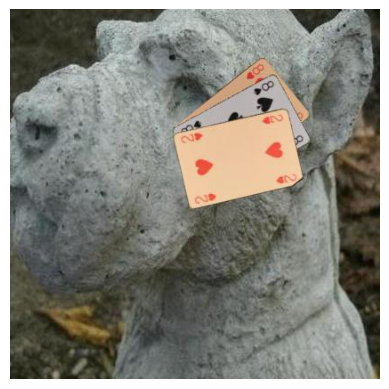

In [8]:
plt.imshow(img.permute(1, 2, 0).numpy())
plt.axis("off")
plt.show()

## Architecture

In [9]:
class ConvolutionBlock(nn.Module):

    def __init__(self, in_c, channels, kernels, strides, pool):
        super(ConvolutionBlock, self).__init__()

        convolutions = [nn.Conv2d(
            in_channels=in_c,
            out_channels=channels[0],
            kernel_size=kernels[0],
            stride=strides[0],
            padding=kernels[0]//2
            ),
            nn.LeakyReLU(negative_slope=0.1)
        ]
        if len(channels) > 1:
            for i in range(len(channels)-1):
                convolutions.append(nn.Conv2d(
                in_channels=channels[i],
                out_channels=channels[i+1],
                kernel_size=kernels[i+1],
                stride=strides[i+1],
                padding=kernels[i+1]//2
                ))
                convolutions.append(nn.LeakyReLU(negative_slope=0.1))
        
        if pool:
            convolutions.append(nn.MaxPool2d(
            kernel_size=pool[0],
            stride=pool[1]
            ))

        self.convolutions = nn.Sequential(*convolutions)


    def forward(self, x):
        return self.convolutions(x)

In [10]:
class Mlp(nn.Module):

    def __init__(self, in_size, hidden_sizes, out_size):
        super(Mlp, self).__init__()

        fully_connected = [
            nn.Linear(
                in_features=in_size,
                out_features=hidden_sizes[0]
            ),
            nn.LeakyReLU(negative_slope=0.1)
        ]
        
        if len(hidden_sizes) > 1:
            for i in range(len(hidden_sizes)-1):
                fully_connected.append(nn.Linear(
                    in_features=hidden_sizes[i],
                    out_features=hidden_sizes[i+1]
                ))
                fully_connected.append(nn.LeakyReLU(negative_slope=0.1))

        fully_connected.append(nn.Linear(
            in_features=hidden_sizes[-1],
            out_features=out_size
        ))

        self.fully_connected = nn.Sequential(*fully_connected)
    
    
    def forward(self, x):
        return self.fully_connected(x)

In [11]:
class YoloV1(nn.Module):

    def __init__(self, yolo_params, convolution_blocks, mlp):
        super(YoloV1, self).__init__()

        self.params = yolo_params
        self.convolutions = nn.ModuleList(
            [
                ConvolutionBlock(
                    in_c=block["in_c"],
                    channels=block["channels"],
                    kernels=block["kernels"],
                    strides=block["strides"],
                    pool=block["pool"]
                ) for block in convolution_blocks
            ]
        )

        self.pool_flatten = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten()
        )

        self.mlp = mlp
    
    
    def forward(self, x):
        for conv in self.convolutions:
            x = conv(x)
        x = self.pool_flatten(x)
        x = self.mlp(x)
        x = x.view(-1, self.params["S"], self.params["S"], self.params["B"]*5 + self.params["C"])

        return x

In [12]:
yolo_v1 = YoloV1(
    yolo_params=YOLO_PARAMS,
    convolution_blocks=convolution_list,
    mlp=Mlp(
        in_size=mlp_dict["in_size"],
        hidden_sizes= mlp_dict["hidden_sizes"],
        out_size=mlp_dict["out_size"]
    )
).to(DEVICE)

summary(yolo_v1, (3, 416, 416), device=DEVICE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 208, 208]           9,472
         LeakyReLU-2         [-1, 64, 208, 208]               0
         MaxPool2d-3         [-1, 64, 104, 104]               0
  ConvolutionBlock-4         [-1, 64, 104, 104]               0
            Conv2d-5        [-1, 192, 104, 104]         110,784
         LeakyReLU-6        [-1, 192, 104, 104]               0
         MaxPool2d-7          [-1, 192, 52, 52]               0
  ConvolutionBlock-8          [-1, 192, 52, 52]               0
            Conv2d-9          [-1, 128, 52, 52]          24,704
        LeakyReLU-10          [-1, 128, 52, 52]               0
           Conv2d-11          [-1, 256, 52, 52]         295,168
        LeakyReLU-12          [-1, 256, 52, 52]               0
           Conv2d-13          [-1, 256, 52, 52]          65,792
        LeakyReLU-14          [-1, 256,

In [13]:
criterion = YOLOv1Loss(
    yolo_params=YOLO_PARAMS
)

optimizer = torch.optim.SGD(
    params=yolo_v1.parameters(),
    lr=CONFIG["lr"],
    momentum=CONFIG["momentum"],
    weight_decay=CONFIG["weight_decay"]
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer,
    mode="min",
    threshold=0.1,
    factor=0.5,
    patience=5,
)

scaler = torch.amp.GradScaler(DEVICE)

## Test

- Add padding to images to get shape 448x448

In [16]:
import tqdm

def train(model, data_loader, criterion, optimizer, scaler, device):
    # Set the model to training mode
    model.train()
    running_loss = 0.0

    bar = tqdm.tqdm(
        total=len(data_loader),
        dynamic_ncols=True,
        leave=False,
        position=0,
        desc="Training",
        unit="batch"
    )

    for batch, (images, labels) in enumerate(data_loader):

        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        # Forward pass
        with torch.amp.autocast(device):
            preds = model(images)
            loss = criterion(preds, labels)
            print(f"Loss: {loss}")

        # Backward pass and optimization
        # scaler.scale(loss).backward()
        # scaler.step(optimizer)
        # scaler.update()
        loss.sum().backward()
        optimizer.step()
        running_loss += loss.sum().item()
            
        bar.set_postfix(
            loss="{:.04f}".format(float(running_loss/(batch+1))),
            lr="{:.04f}".format(float(optimizer.param_groups[0]["lr"]))
        )
        bar.update()

        # Empty the cache
        del images, labels, preds, loss
        torch.cuda.empty_cache()
    
    train_loss = running_loss/len(data_loader)
    return train_loss

In [17]:
loss = train(
    model=yolo_v1,
    data_loader=train_loader,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=DEVICE
)

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Loss: tensor([14.9774, 31.7382], grad_fn=<AddBackward0>)


Training:  33%|███▎      | 1/3 [01:28<02:56, 88.30s/batch, loss=46.7155, lr=0.0050]

Loss: tensor([18.9652, 15.5483], grad_fn=<AddBackward0>)


Training:  67%|██████▋   | 2/3 [02:48<01:23, 83.63s/batch, loss=40.6145, lr=0.0050]

Loss: tensor([18.2914], grad_fn=<AddBackward0>)


In [16]:
pred = yolo_v1(batch.to(DEVICE))
true = batch_label.to(DEVICE)

In [17]:
def compute_iou(box1_center, box1_size, box2_center, box2_size):
    
    box1_min = box1_center - box1_size/2
    box1_max = box1_center + box1_size/2
    box2_min = box2_center - box2_size/2
    box2_max = box2_center + box2_size/2

    # Intersection area
    inter_min = torch.max(box1_min, box2_min)
    inter_max = torch.min(box1_max, box2_max)
    intersection_area = torch.clamp(inter_max-inter_min, min=0)
    intersection_area = intersection_area.prod(dim=-1)

    # Union area
    box1_area = box1_size.prod(dim=-1)
    box2_area = box2_size.prod(dim=-1)
    union_area = box1_area + box2_area - intersection_area

    # IoU
    iou = intersection_area/(union_area+1e-6)
    return iou

In [20]:
B = YOLO_PARAMS["B"]
lambda_coord = 5
lambda_noobj = 0.5

# Get a mask for the position of the object in the grid cell
# This is specific to YOLOv1, as a cell is responsible for predicting an object if it falls into it
object_mask = true[..., 4].unsqueeze(-1)

# Get indexes of the boxes responsible for each cell
ious = torch.cat([compute_iou(
    pred[..., b*5:b*5+2],
    pred[..., b*5+2:b*5+4],
    true[..., :2],
    true[..., 2:4]
).unsqueeze(0) for b in range(B)], dim=0)
best_box = torch.argmax(ious, dim=0).unsqueeze(-1)

# Mask out the predicted coordinates of the boxes that are not responsible for the object
# pred_box_masked = object_mask*(best_box*pred[..., 5:9] + (1-best_box)*pred[..., :4])
pred_box_masked = sum([
    object_mask*(best_box == b) * pred[..., b*5:b*5+4]
    for b in range(B)
])

# Mask out the true coordinates of the boxes that are not responsible
true_box_masked = object_mask*true[..., :4]

# Take the square root of the width and height of the boxes
pred_box_masked[..., 2:4] = torch.sign(pred_box_masked[..., 2:4]) * torch.sqrt(torch.abs(pred_box_masked[..., 2:4])+1e-6)
true_box_masked[..., 2:4] = torch.sqrt(true_box_masked[..., 2:4])


# 1. Compute the coordinate loss for the cells that contain an object
coord_loss = lambda_coord * torch.sum((pred_box_masked - true_box_masked)**2, dim=[1, 2, 3])


# 2. Compute the confidence loss for the cells that contain an object
pred_conf_obj_masked = sum([
    object_mask*(best_box == b) * pred[..., b*5+4].unsqueeze(-1)
    for b in range(B)
])
true_conf_obj_masked = object_mask*true[..., 4].unsqueeze(-1)

obj_conf_loss = torch.sum((pred_conf_obj_masked - true_conf_obj_masked)**2, dim=[1, 2, 3])


# 3. Compute the confidence loss for the cells that do not contain an object
pred_conf_noobj_masked = sum([
    (1-object_mask)*(best_box == b) * pred[..., b*5+4].unsqueeze(-1)
    for b in range(B)
])
true_conf_noobj_masked = (1-object_mask) * true[..., 4].unsqueeze(-1)
noobj_conf_loss = lambda_noobj * torch.sum((pred_conf_noobj_masked - true_conf_noobj_masked)**2, dim=[1, 2, 3])

# 4. Compute the class loss for the cells that contain an object
class_loss = torch.sum((true[..., 5:]-pred[..., B*5:])**2, dim=-1).unsqueeze(-1)
print("Object mask shape:", object_mask.shape)
print("Class loss shape:", class_loss.shape)
class_loss_masked = torch.sum((object_mask * class_loss), dim=[1, 2, 3])

total_loss = coord_loss + obj_conf_loss + noobj_conf_loss + class_loss_masked

Object mask shape: torch.Size([2, 7, 7, 1])
Class loss shape: torch.Size([2, 7, 7, 1])


## Detect cards